In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import seaborn as sns

In [5]:
print(sc.__version__)

1.4.4.post1


In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

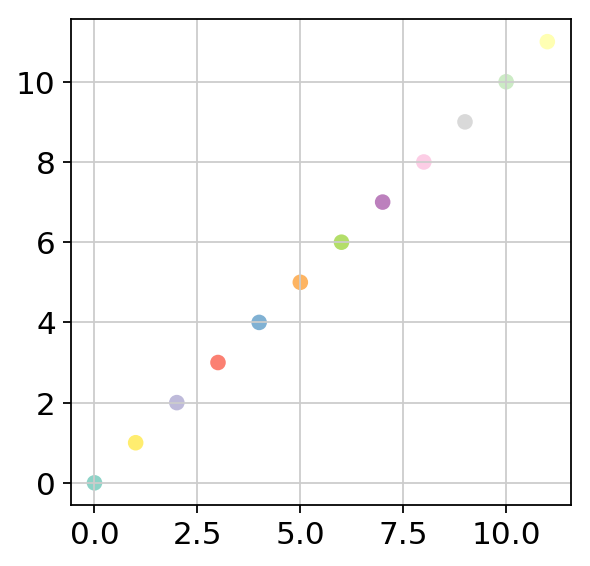

In [4]:
plt.scatter(np.arange(12), np.arange(12), c=['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3'])
colors = dict(zip(['turq','dark yel','light purp','coral','blue','orange','light gr','purp','pink','gray','mint','light yel'],
                  ['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3']))

### Load in the XYZeq Dataset

In [7]:
data = dict()

In [17]:
data['l20c1'] = dict()
data['l20c1']['raw'] = sc.read_h5ad(prefix + 'xyzeq/individual.raw.and.proc.h5ads/fig3.L20C1/adata.1.h5ad')
data['l20c1']['processed'] = sc.read_loom(prefix + 'xyzeq/individual.raw.and.proc.h5ads/20200324/L20C1_mouse_wTSNE.loom')

In [18]:
print(data['l20c1']['raw'].var_names[:5])
print(data['l20c1']['processed'].var_names[:5])

Index(['hg19_RP11-34P13.7', 'hg19_AL627309.1', 'hg19_AP006222.2',
       'hg19_RP4-669L17.10', 'hg19_OR4F29'],
      dtype='object', name='index')
Index(['GRCh38_PRDM16', 'GRCh38_VPS13D', 'GRCh38_KDM1A', 'GRCh38_RPL11',
       'GRCh38_CTPS1'],
      dtype='object')


Replace the cellranger-assigned names with shorter, easier ones.

In [19]:
for tag, dataset in zip(['hg19_','GRCh38_'],['raw','processed']):
    new_names = list()
    for i in data['l20c1'][dataset].var_names:
        if i.startswith(tag):
            new_names.append('H_' + i[len(tag):])
        else:
            new_names.append('m_' + i[len(tag):])
    data['l20c1'][dataset].var_names = new_names

Show the UMAP that Derek generated, which is the current iteration of this dataset.

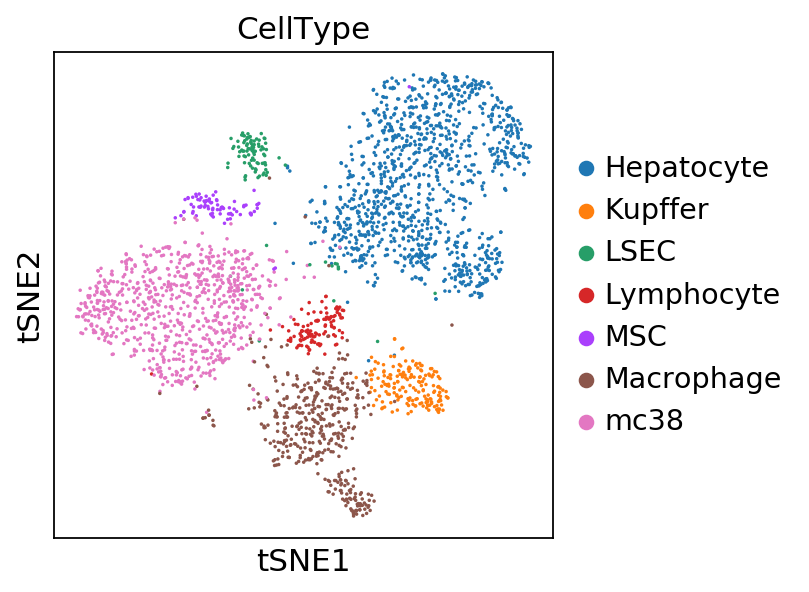

In [21]:
sc.pl.tsne(data['l20c1']['processed'],color=['CellType'], size=10)

Change the names just to match what's currently part of the figures.

In [22]:
ctdict = dict()

ctdict['Hepatocytes'] = ['Hepatocyte']
ctdict['Macrophages'] = ['Macrophage']
ctdict['Lymphocytes'] = ['Lymphocyte']
ctdict['LSECs'] = ['LSEC']
ctdict['Kupffer cells'] = ['Kupffer']
ctdict['MSCs'] = ['MSC']
ctdict['MC38'] = ['mc38']

for ct in ctdict:
    for clust in ctdict[ct]:
        data['l20c1']['processed'].obs['CellType'].replace(r'^%s$' % str(clust), ct, regex=True, inplace=True)

Change the colors to match what's currently part of the figures.

In [25]:
data['l20c1']['processed'].uns['CellType_colors'] = [
    colors['coral'],
    colors['orange'],
    colors['blue'], 
    colors['purp'],
    colors['dark yel'],
    colors['turq'],
    colors['mint']
]

... storing 'CellType' as categorical


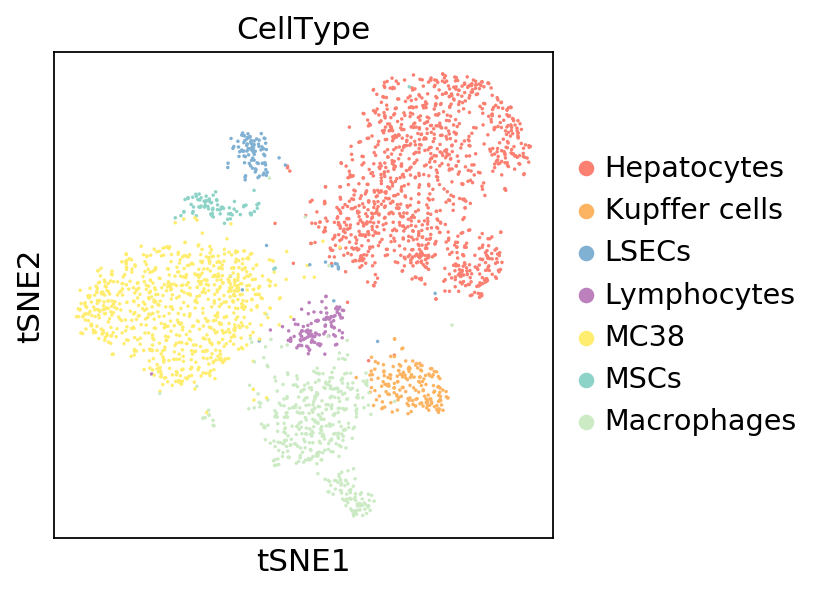

In [26]:
sc.pl.tsne(data['l20c1']['processed'],color=['CellType'], size=10)

### Load in the 10x Dataset

In [51]:
data['10x'] = dict()

In [80]:
data['10x']['raw'] = sc.read_10x_h5(prefix + '10x/5prime_liver/outs/raw_feature_bc_matrix.h5')
data['10x']['raw'].var_names_make_unique()

data['10x']['adata_h'] = data['10x']['raw'].copy()
data['10x']['adata_h'].var_names_make_unique()
data['10x']['adata_h'] = data['10x']['adata_h'][:, [i for i in data['10x']['raw'].var_names if i.startswith('GRCh38_')]].copy()

data['10x']['adata_m'] = data['10x']['raw']
data['10x']['adata_m'].var_names_make_unique()
data['10x']['adata_m'] = data['10x']['adata_m'][:, [i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].copy()

reading /data/xyzeq/10x/5prime_liver/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Visualize the knee plot to draw a cutoff for the 10x cells. There was high background in this data.

In [81]:
for adata in ['adata_h', 'adata_m']:
    sc.pp.filter_cells(data['10x'][adata], min_counts=1)
    sc.pp.filter_genes(data['10x'][adata], min_counts=1)
    data['10x'][adata + '-filter_cells_n_counts'] = data['10x'][adata].obs['n_counts'].sort_values(ascending=False)

filtered out 533042 cells that haveless than 1 counts
filtered out 13298 genes that are detectedin less than 1 counts
filtered out 519834 cells that haveless than 1 counts
filtered out 12235 genes that are detectedin less than 1 counts


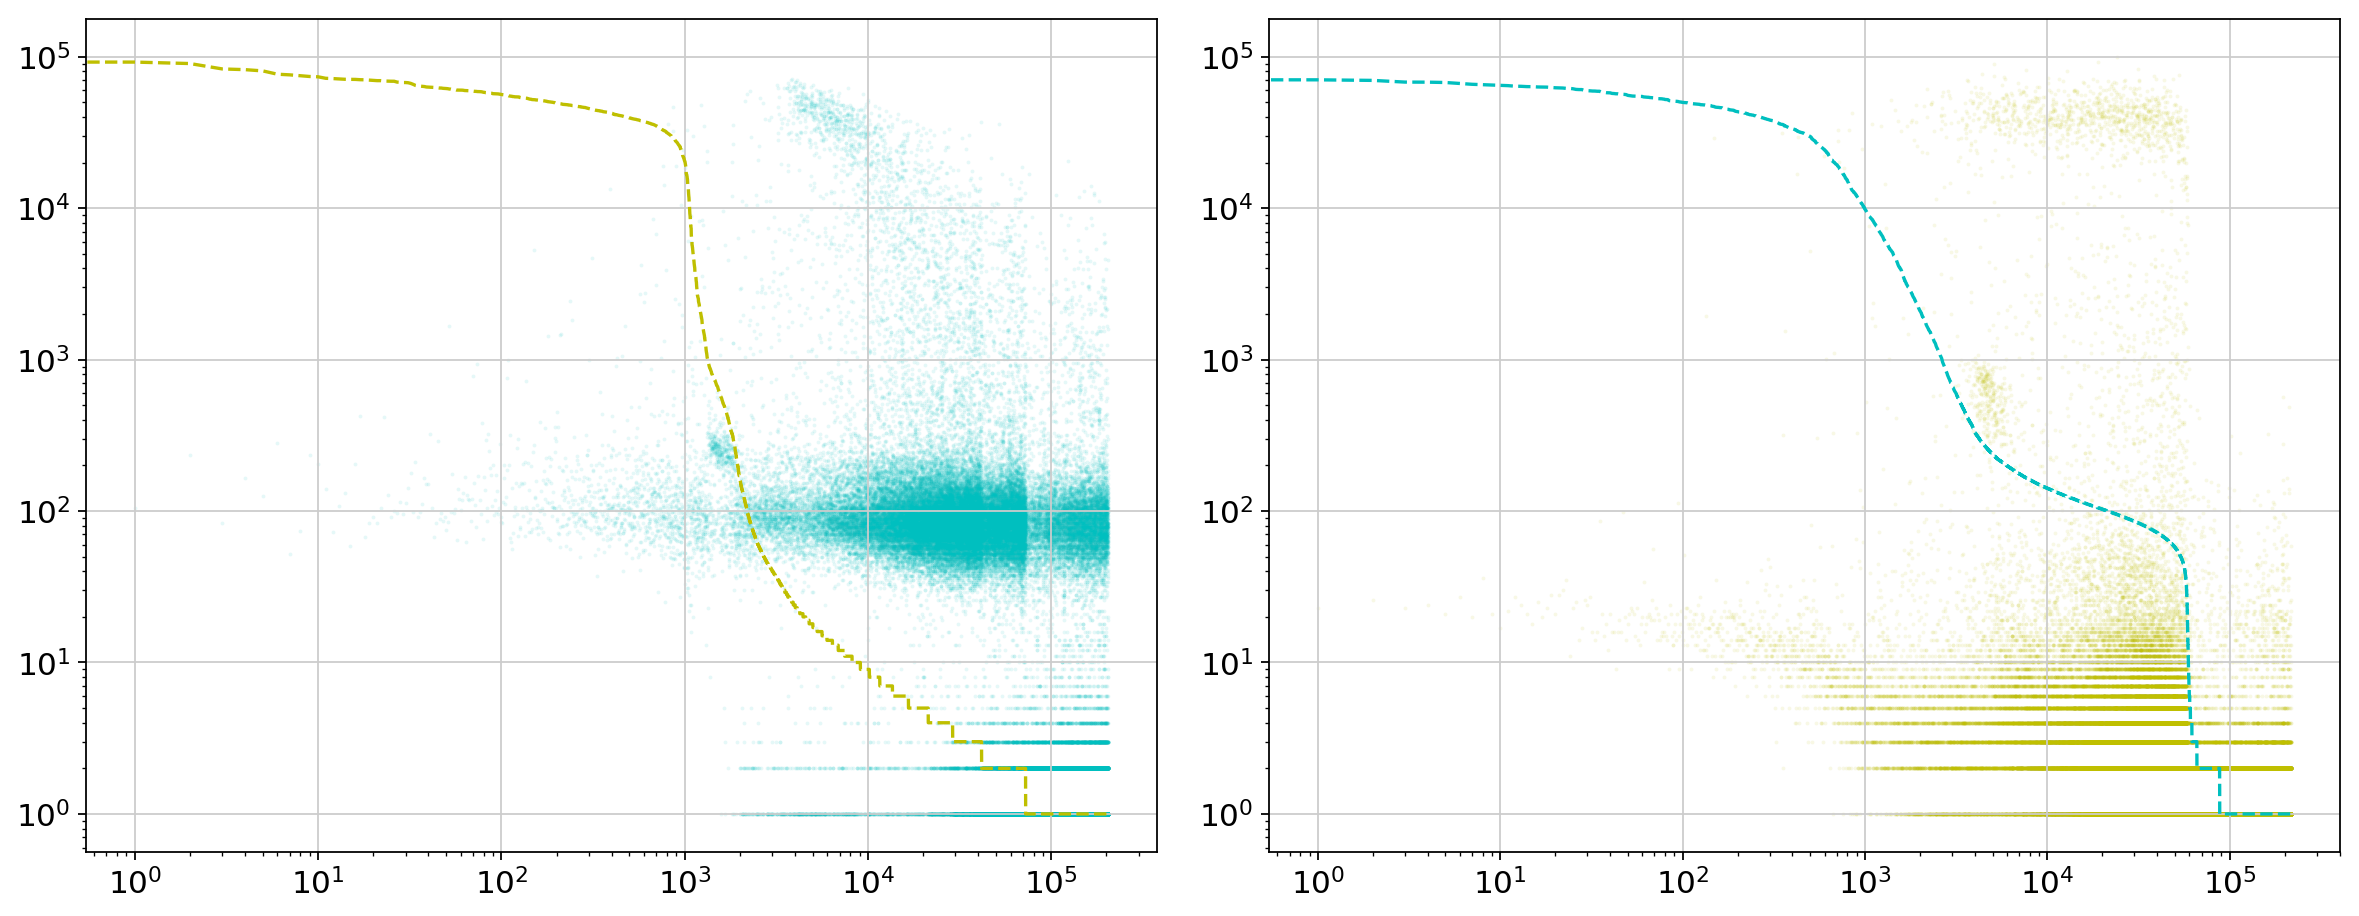

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
for prod, ax in tqdm(list(zip(['adata_h', 'adata_m'], np.ravel(ax.T))), total=2):
    series = data['10x'][prod + '-filter_cells_n_counts']
    if prod == 'adata_h':
        ax.scatter(range(len(series)), data['10x']['adata_m'].obs['n_counts'][series.index.values].values, color='c', alpha=0.1, s=3, linewidth='0')
        ax.plot(series.values, color='y', linestyle='--')
    else:
        ax.scatter(range(len(series)), data['10x']['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth='0')
        ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.tight_layout()

In [82]:
mouse_hi_umi_cells = data['10x']['adata_m'].obs_names[data['10x']['adata_m'].obs['n_counts'] > 5e2].values
lo_umi_human_cells = data['10x']['adata_h-filter_cells_n_counts'][2000:].index.values

human_hi_umi_cells = data['10x']['adata_h'].obs_names[data['10x']['adata_h'].obs['n_counts'] > 1e3].values
lo_umi_mouse_cells = data['10x']['adata_m-filter_cells_n_counts'][2000:].index.values

mouse_cells = np.intersect1d(mouse_hi_umi_cells, lo_umi_human_cells)
human_cells = np.intersect1d(human_hi_umi_cells, lo_umi_mouse_cells)

data['10x']['adata_m'] = data['10x']['adata_m'][mouse_cells,:].copy()
data['10x']['adata_h'] = data['10x']['adata_h'][human_cells,:].copy()

data['10x']['adata_m'].var_names = [i[7:] for i in data['10x']['adata_m'].var_names]
data['10x']['adata_h'].var_names = [i[7:] for i in data['10x']['adata_h'].var_names]

Threshold %mito.

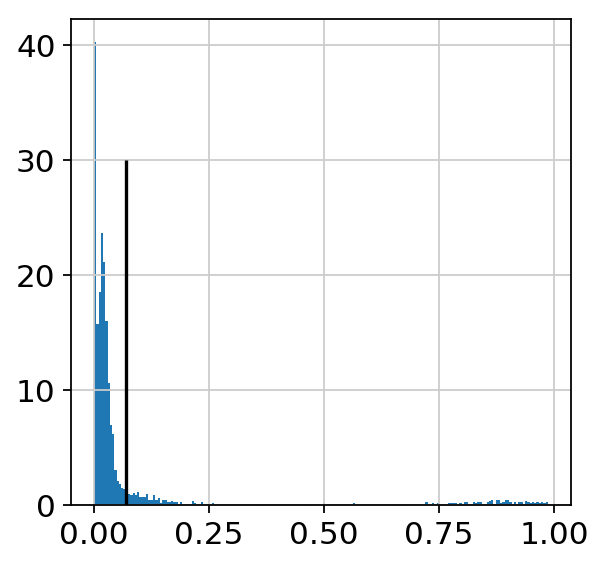

In [83]:
genelist = data['10x']['adata_m'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['10x']['adata_m'][:, mito_genes].X, axis=1))

data['10x']['adata_m'].obs['percent_mito'] = mito_counts / data['10x']['adata_m'].obs['n_counts'].values
plt.hist(data['10x']['adata_m'].obs['percent_mito'].values,bins=200,density=True);
plt.vlines(0.07, 0, 30);

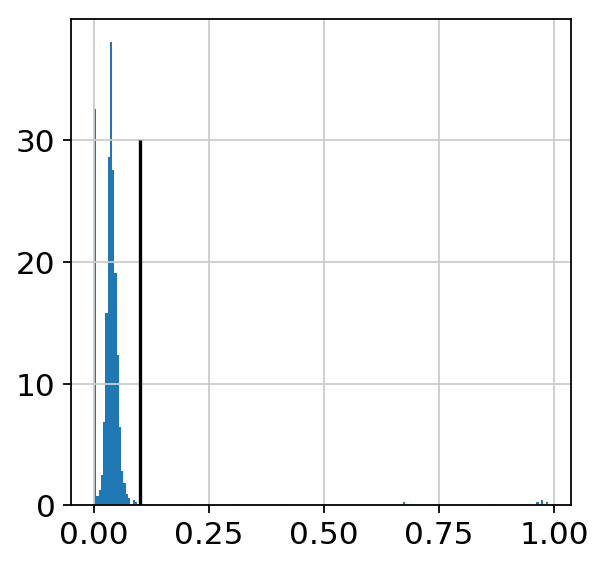

In [84]:
genelist = data['10x']['adata_h'].var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('MT-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(data['10x']['adata_h'][:, mito_genes].X, axis=1))

data['10x']['adata_h'].obs['percent_mito'] = mito_counts / data['10x']['adata_h'].obs['n_counts'].values
plt.hist(data['10x']['adata_h'].obs['percent_mito'].values,bins=200,density=True);
plt.vlines(0.1, 0, 30);

In [85]:
data['10x']['adata_h'] = data['10x']['adata_h'][data['10x']['adata_h'].obs['percent_mito'] < 0.1].copy()
data['10x']['adata_m'] = data['10x']['adata_m'][data['10x']['adata_m'].obs['percent_mito'] < 0.07].copy()

vals_h = data['10x']['adata_h'].var['n_counts'].sort_values(ascending=False).values
vals_m = data['10x']['adata_m'].var['n_counts'].sort_values(ascending=False).values

for adata in ['adata_h', 'adata_m']:
    sc.pp.filter_cells(data['10x'][adata], min_counts=1)
    sc.pp.filter_genes(data['10x'][adata], min_counts=1)

filtered out 162 genes that are detectedin less than 1 counts
filtered out 290 genes that are detectedin less than 1 counts


Put back genome identifiers on gene names.

In [86]:
data['10x']['adata_m'].var_names = ['m_' + i for i in data['10x']['adata_m'].var_names]
data['10x']['adata_h'].var_names = ['H_' + i for i in data['10x']['adata_h'].var_names]

In [87]:
data['10x']['processed'] = data['10x']['adata_m'].concatenate(data['10x']['adata_h'],join='outer')

data['10x']['processed'].obs_names = [i[:18] for i in data['10x']['processed'].obs_names]

data['10x']['processed'].obs['n_counts_H'] = data['10x']['raw'][data['10x']['processed'].obs_names,:].copy()[:, [i for i in data['10x']['raw'].var_names if i.startswith('GRCh38_')]].X.sum(axis=1)
data['10x']['processed'].obs['n_counts_m'] = data['10x']['raw'][data['10x']['processed'].obs_names,:].copy()[:, [i for i in data['10x']['raw'].var_names if i.startswith('mm10___')]].X.sum(axis=1)

In [88]:
sc.pp.log1p(data['10x']['processed'])
sc.pp.normalize_per_cell(data['10x']['processed'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [89]:
sc.pp.log1p(data['10x']['adata_m'])
sc.pp.normalize_per_cell(data['10x']['adata_m'])

sc.pp.log1p(data['10x']['adata_h'])
sc.pp.normalize_per_cell(data['10x']['adata_h'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [61]:
# common_genes = np.intersect1d(data['10x']['processed'].var_names.values, data['l20c1']['processed'].var_names.values)

In [62]:
# data['10x']['processed'] = data['10x']['processed'][:,common_genes].copy()

In [95]:
sc.pp.scale(data['10x']['processed'], max_value=10)

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    ... clipping at max_value 10


In [96]:
sc.pp.pca(data['10x']['processed'],n_comps=200)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 200
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


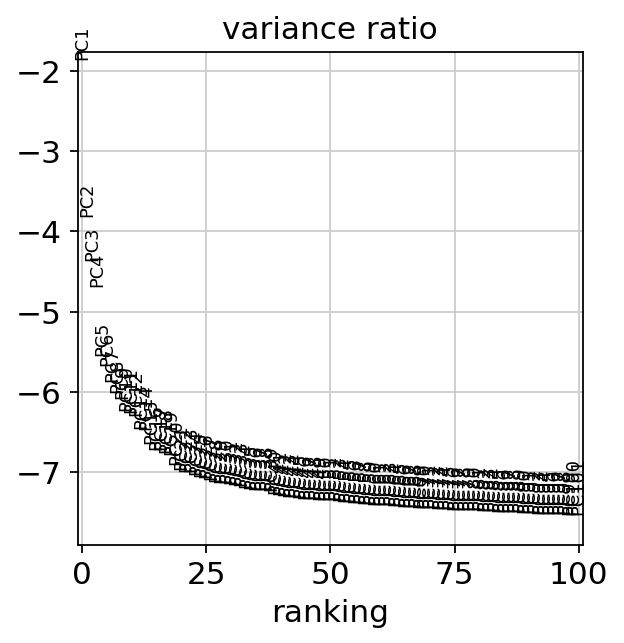

In [97]:
sc.pl.pca_variance_ratio(data['10x']['processed'], log=True, n_pcs=100)

In [100]:
warnings.filterwarnings("ignore")
sc.pp.neighbors(data['10x']['processed'],n_neighbors=15, n_pcs=20)
sc.tl.umap(data['10x']['processed'], alpha=2)
sc.tl.leiden(data['10x']['processed'], resolution=1)
warnings.filterwarnings("default")

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 20
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


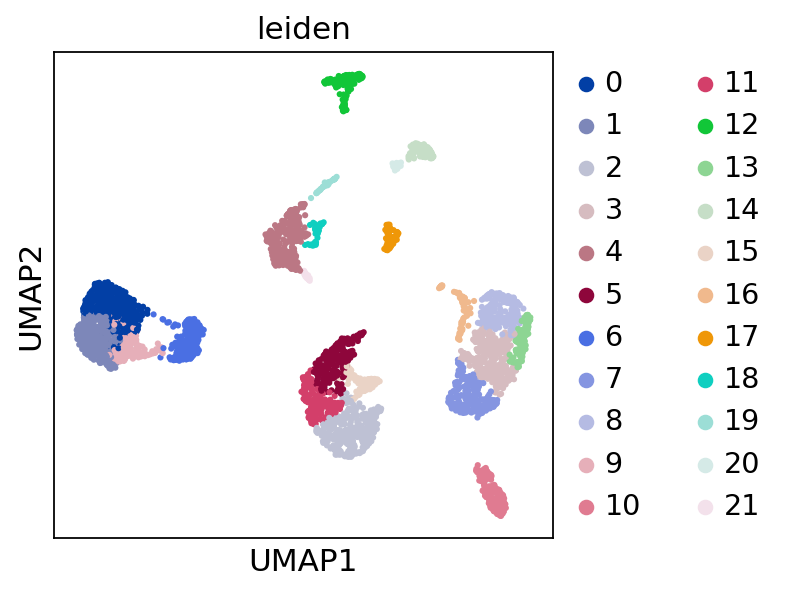

In [101]:
sc.pl.umap(data['10x']['processed'], color='leiden')